# t-SNE on wavelet transforms

In [49]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities


one = ONE(mode='remote')

## Parameters

In [44]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_iters = 100
num_train_batches = 5
method = 'kmeans'
method='prior'
threshold = 0.05
sticky = False

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

var_interest = 'wavelet'


# Sessions with cross-validated results

In [45]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if not os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


In [46]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]


for m, mat in enumerate(sessions_to_process[:1]): 
    
    mouse_name = mat[0]
    session = mat[1]

    fit_id = str(mouse_name+session)
    
    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]

    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)


## t-SNE

In [57]:
X = data.copy()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
X_embedded.shape

(281680, 2)

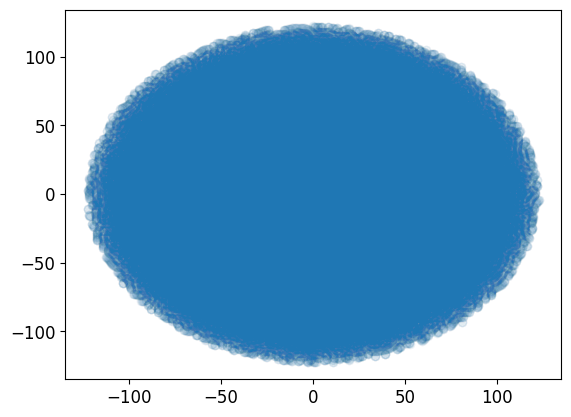

In [50]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.02)

Text(0, 0.5, 'UMAP 2')

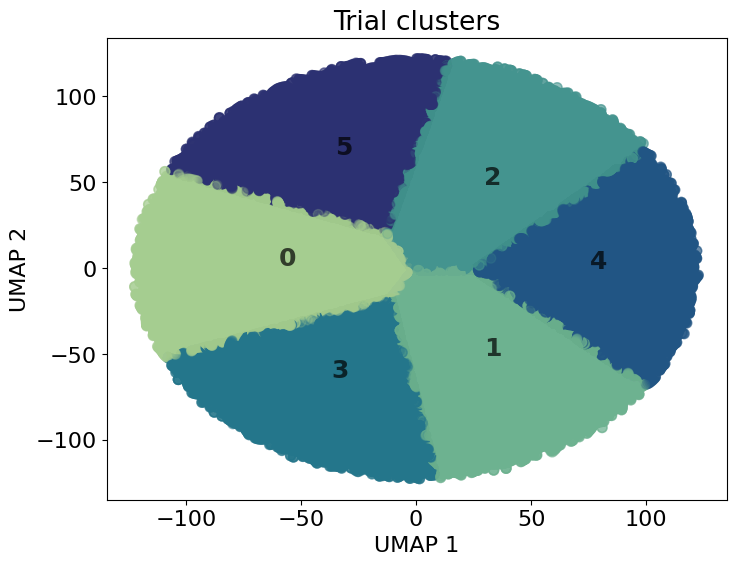

In [53]:
# Step 2: Perform KMeans Clustering
data_2d = X_embedded.copy()
data_2d = X.copy()
kmeans = KMeans(n_clusters=6, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans, s=50, alpha=0.2, cmap=sns.color_palette("crest", as_cmap=True)) # , cmap='Set2'

# Plot the centroids
centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')


plt.title("Trial clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")


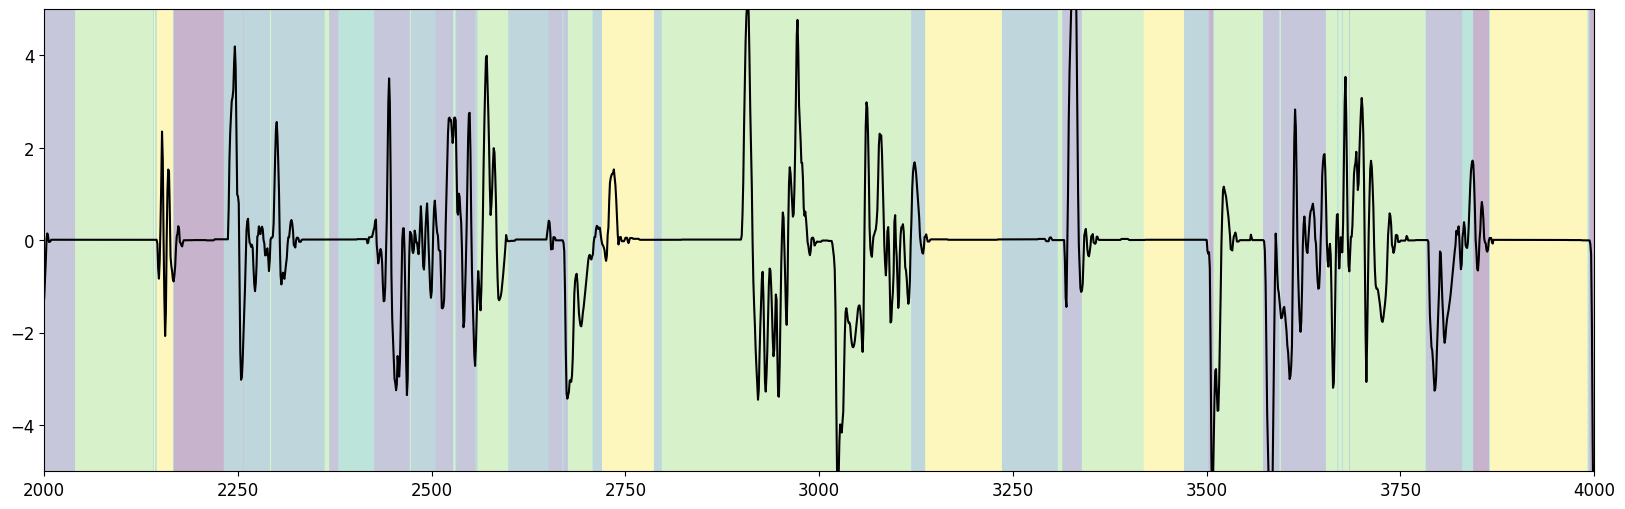

In [59]:
# Plot raw trace over states
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)

# ax.plot(data)
ax.plot(filtered_matrix[:len(data), 0], color='black')
ax.imshow(np.concatenate([y_kmeans])[None,:], 
            extent=(0, len(np.concatenate([y_kmeans])), -5, 5),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
    
init = 2000
ax.set_xlim([init, init+2000])
ax.set_ylim([-5, 5])

plt.show()